<a href="https://colab.research.google.com/github/daddyprasad5/thinkful/blob/master/rfc_spark_batch_02_26_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you'll learn the basics of working with Spark in batch mode to build a random forest classifier. Note that this notebook is intended to be run on Google Colaboratory.

## Spark and Colaboratory setup

First, there's some configration specific to running Spark on Colaboratory that we'll need to attend to. Run these cells to set everything up.

In [0]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !tar xf spark-2.4.0-bin-hadoop2.7.tgz

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz

In [2]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 215.6MB 102kB/s 
     |████████████████████████████████| 204kB 41.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [5]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##  Import dependencies

Next, we need to import the tools we'll need from PySpark. The imports below allow us to connect to the Spark server, load our data, clean it, and prepare, execute, and evaluate a model.

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import isnan, when, count, col

## Set our constants

Next, we create a set of constants that we can refer to throughout the notebook. These are values that the rest of our code needs to run, but that we might need to change at some point (for instance, if the location of our data changes). 

If you saved the relevant datasets in the folders suggested in the previous checkpoint (link), you can use the below code chunk as is. If you saved the datasets elsewhere on your Google Drive, modify the file path after the `My Drive` folder. 

Regardless of the exact file path, these datasets **must** be stored on Google Drive!

In [0]:
CSV_PATH = "/content/gdrive/My Drive/Colab Datasets/allData.csv" 
CSV_ACTIVITY_LABEL_PATH = "/content/gdrive/My Drive/Colab Datasets/activity_labels.csv"
APP_NAME = "UCI HAR Random Forest Example"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

## Connect to the server and load data

Now we're ready to connect to the Spark server. We do that (relying on the constants set above) and then load our labels (loaded into `activity_labels`) and activity data (loaded into `df`). 

In [0]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
activity_labels = spark.read.options(inferschema = "true").csv(CSV_ACTIVITY_LABEL_PATH)
df = spark.read.options(inferschema = "true").csv(CSV_PATH)

## Validate the data

If our data has been properly cleaned and prepared, it will meet the following criteria, which we'll verify in just a moment:

* The dataframe shape should be 10,299 rows by 562 columns
* All feature columns should be doubles. Note that one of the columns is for our labels and it will not be double.
* There should be no nulls. This point is crucial because Spark will fail to build our vector variables for our classifier if there are any null values.

Let's confirm these points.

In [9]:
# Confirm the dataframe shape is 10,299 rows by 562 columns
print(f"Dataset shape is {df.count():d} rows by {len(df.columns):d} columns.")

Dataset shape is 10299 rows by 562 columns.


In [10]:
# Confirm that all feature columns are doubles via a list comprehension
# We're expecting 561 of 562 here, accounting for the labels column
double_cols = [col[0] for col in df.dtypes if col[1] == 'double']
print(f"{len(double_cols):d} columns out of {len(df.columns):d} total are type double.")

561 columns out of 562 total are type double.


In [11]:
# Confirm there are no null values. We use the dataframe select method to build a 
# list that is then converted to a Python dict. This way it's easy to sum up the nulls.
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

print(f"There are {sum(null_counts[0].values()):d} null values in the dataset.")

There are 0 null values in the dataset.


## Set up and run our classifier in Spark

After confirming our data is clean, we're ready to reshape the data and run the random forest model.

In Spark, we manipulate the data to work in a Spark pipeline, define each of the steps in the pipeline, chain them together, and finally run the pipeline.

Apache Spark classifiers expect 2 columns of input:

1. __labels__: an indexed set of numeric variables that represent the classification from the set of features we provide.
2. __features__: an indexed, vector variable that contains all of the feature values in each row. 

In order to do this, we need to create these 2 columns from our dataset - the data is there, but not yet in a format we can use for the classifier.

To create the indexed labels column, we'll create a column called `indexedLabel` using the `StringIndexer` method. We use the column `_c0` as the source for our label index since that contains our labels. The column contains only one value per index.
    
To create the indexed features column, we'll need to do two things. First, we'll create the vector of features using the `VectorAssembler` method. To create this vector, we'll need to use all 561 numeric columns from our data frame. The vector assembler will create a new column called `features`, and each row of this column will contain a 561-element vector that is built from the 561 features in the dataset.

Finally, we'll complete the data preparation by creating an indexed vector from the `features` column. We'll call this vector `indexedFeatures`.
    
Since the classifier expects indexed labels and an indexed vector column of data, we'll use the `indexedLabel` and `indexedFeatures` as inputs to our random forest classifier.

In [0]:
# Generate our feature vector.
# Note that we're doing the work on the `df` object - we don't create new dataframes, 
# just add columns to the one we already are using.

# the transform method creates the column.

df = VectorAssembler(inputCols=double_cols, outputCol="features").transform(df)

Let's confirm that the features are there. It's easy to do this in Apache Spark using the `select` and `show` methods on the dataframe.  

In [13]:
df.select("_c0", "features").show(5)

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  5|[0.289,-0.0203,-0...|
|  5|[0.278,-0.0164,-0...|
|  5|[0.28,-0.0195,-0....|
|  5|[0.279,-0.0262,-0...|
|  5|[0.277,-0.0166,-0...|
+---+--------------------+
only showing top 5 rows



Now we're ready to build the indexers, split our data for training and testing, define our model, and finally chain everything together into a pipeline.

__It's important to note that when we execute this cell, we're not actually running our model. At this point, we're only defining its parameters__.

In [0]:
# Build the training indexers / split data / classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="_c0", outputCol="indexedLabel").fit(df)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

This next cell runs the pipeline, delivering a trained model at the end of the process.

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

It is now easy to test our model and make predictions simply by using the model's `transform` method on the `testData` dataset.

In [0]:
# Make predictions.
predictions = model.transform(testData)

## Evaluate the model

Now we can use the MulticlassClassificationEvaluator to test the model's accuracy.

In [17]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.0918017
Accuracy = 0.908198


## Next Steps

We've seen how to prepare data and build a classifier in Spark. You might want to play around with this notebook and learn more about how Spark works. Here are some ideas:

- Look at the set of labels, and see if there are any features that would make sense to combine. Spark allows you to map values into a new column.
- Identify the most important features among the 561 source features (using PCA or something similar), then reduce the feature set and see if the model performs better.
- Modify the settings of the random forest to see if the performance improves.
- Use Spark's tools to find other techniques to evaluate the performance of your model. See if you can figure out how to generate an ROC plot, find the AUC value, or plot a confusion matrix.

In [95]:
#create a simpler features set using PCA and see if it improves the accuracy
#(it doesn't)

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

#copy the training and testing datasets
training2 = trainingData.withColumnRenamed("features", "old_features")
testing2 = testData.withColumnRenamed("features", "old_features")

#calculate the PCA components for the two datasets
pca = PCA(k=200, inputCol="old_features", outputCol="features")
pca_model = pca.fit(training2)
pca_training = pca_model.transform(training2)
pca_testing = pca_model.transform(testing2)

#create a new pipeline with a new indexer
featureIndexer_pca = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pca_training)
pipeline_pca = Pipeline(stages=[labelIndexer, featureIndexer_pca, rf])

#fit the model, make predictions
simpler_pca_model = pipeline_pca.fit(pca_training)
pca_predictions = simpler_pca_model.transform(pca_testing)

#evaluate the accuracy of the predictions
pca_evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = pca_evaluator.evaluate(pca_predictions)
print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")


Test Error = 0.203731
Accuracy = 0.796269


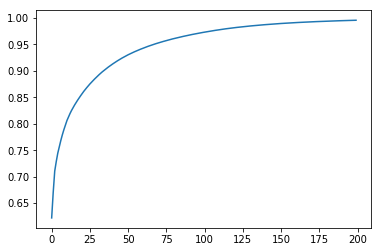

In [90]:
#BTW - chose 200 PCA components because the explained variance tails off after 
#about 200 components. 

import seaborn as sns

cum_expl_variance = []

for index, ev in enumerate(pca_model.explainedVariance): 
  if index == 0:
    cum_expl_variance.append(ev)
  else: 
    cum_expl_variance.append(cum_expl_variance[index-1] + ev)

sns.lineplot(x=range(len(cum_expl_variance)), y=cum_expl_variance)

In [89]:
#get a confusion matrix for the originial model predictons
#note that confusion matrix isn't yet available in pyspark.ml, 
#so we must use the pyspark.mllib.evaluation package.
#that requires converting the predictions dataframe to an RDD. 

from pyspark.mllib.evaluation import MulticlassMetrics

predictionsAndLabels2 = predictions.select("prediction", "indexedLabel").rdd.map(tuple)
metrics = MulticlassMetrics(predictionsAndLabels)
metrics.confusionMatrix().toArray()


array([[368.,   0.,   1.,   0.,   2.,   0.],
       [  0., 300.,  42.,   0.,   1.,   0.],
       [  0.,  42., 303.,   0.,   0.,   0.],
       [  0.,   0.,   0., 327.,  18.,   6.],
       [  0.,   0.,   0.,  14., 314.,   6.],
       [  0.,   0.,   0.,  23.,  32., 238.]])

In [0]:
#tune the random forest model

from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()


In [0]:
#evaluate the models with 3 fold cross-validation

from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
                              labelCol="indexedLabel", 
                              predictionCol="prediction"),
                          numFolds=3)

In [0]:
cvModel = crossval.fit(trainingData)

In [106]:
#prediction and evaluation - tiny improvement
predictions_tuned = cvModel.transform(testData)

#evaluate the accuracy of the predictions
tuned_evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = tuned_evaluator.evaluate(predictions_tuned)
print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.086182
Accuracy = 0.913818


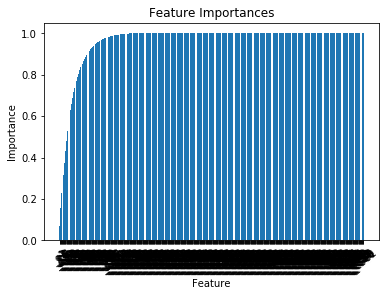

561
88 features required to reach 0.98 target importance


In [139]:
import matplotlib.pyplot as plt

bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]

importances = bestModel.featureImportances
feature_cols = double_cols
imp_tup = sorted(zip(importances, feature_cols), reverse=True)

cum_imp = []
for i, tup in enumerate(imp_tup):
  if i == 0:
    cum_imp.append(tup[0])
  else: 
    cum_imp.append(tup[0] + cum_imp[i-1])

cum_imp_tuple = list(zip(cum_imp, feature_cols))

sorted_imp = [t[0] for t in cum_imp_tuple]
sorted_feat_col = [t[1] for t in cum_imp_tuple]

x_values = list(range(len(sorted_imp)))

plt.bar(x_values, sorted_imp, orientation = 'vertical')
plt.xticks(x_values, sorted_feat_col, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

target_cum_imp = .98

top_features = []
print(len(cum_imp_tuple))
for f in cum_imp_tuple:
  top_features.append(f[1])
  if f[0] >= target_cum_imp:
    break

print(f"{len(top_features)} features required to reach {target_cum_imp} target importance")

In [164]:
#refit the model with just the top features
df_mi = spark.read.options(inferschema = "true").csv(CSV_PATH)
df_mi = VectorAssembler(inputCols=top_features, outputCol="features").transform(df_mi)
labelIndexer = StringIndexer(inputCol="_c0", outputCol="indexedLabel").fit(df_mi)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_mi)
(training_mi, test_mi) = df_mi.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])
pipeline_mi = Pipeline(stages=[labelIndexer, featureIndexer, rf])

#redefine the crossvalidator to use the new pipeline
crossval = CrossValidator(estimator=pipeline_mi,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
                              labelCol="indexedLabel", 
                              predictionCol="prediction"),
                          numFolds=3)

#predict with the new model
cvModel_mi = crossval.fit(training_mi)
predictions_mi = cvModel_mi.transform(test_mi)

#evaluate the accuracy of the predictions
evaluator_mi = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_mi.evaluate(predictions_mi)
print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")


Test Error = 0.0388676
Accuracy = 0.961132


Looks like removing some useless features made the tree more accurate. Nice!